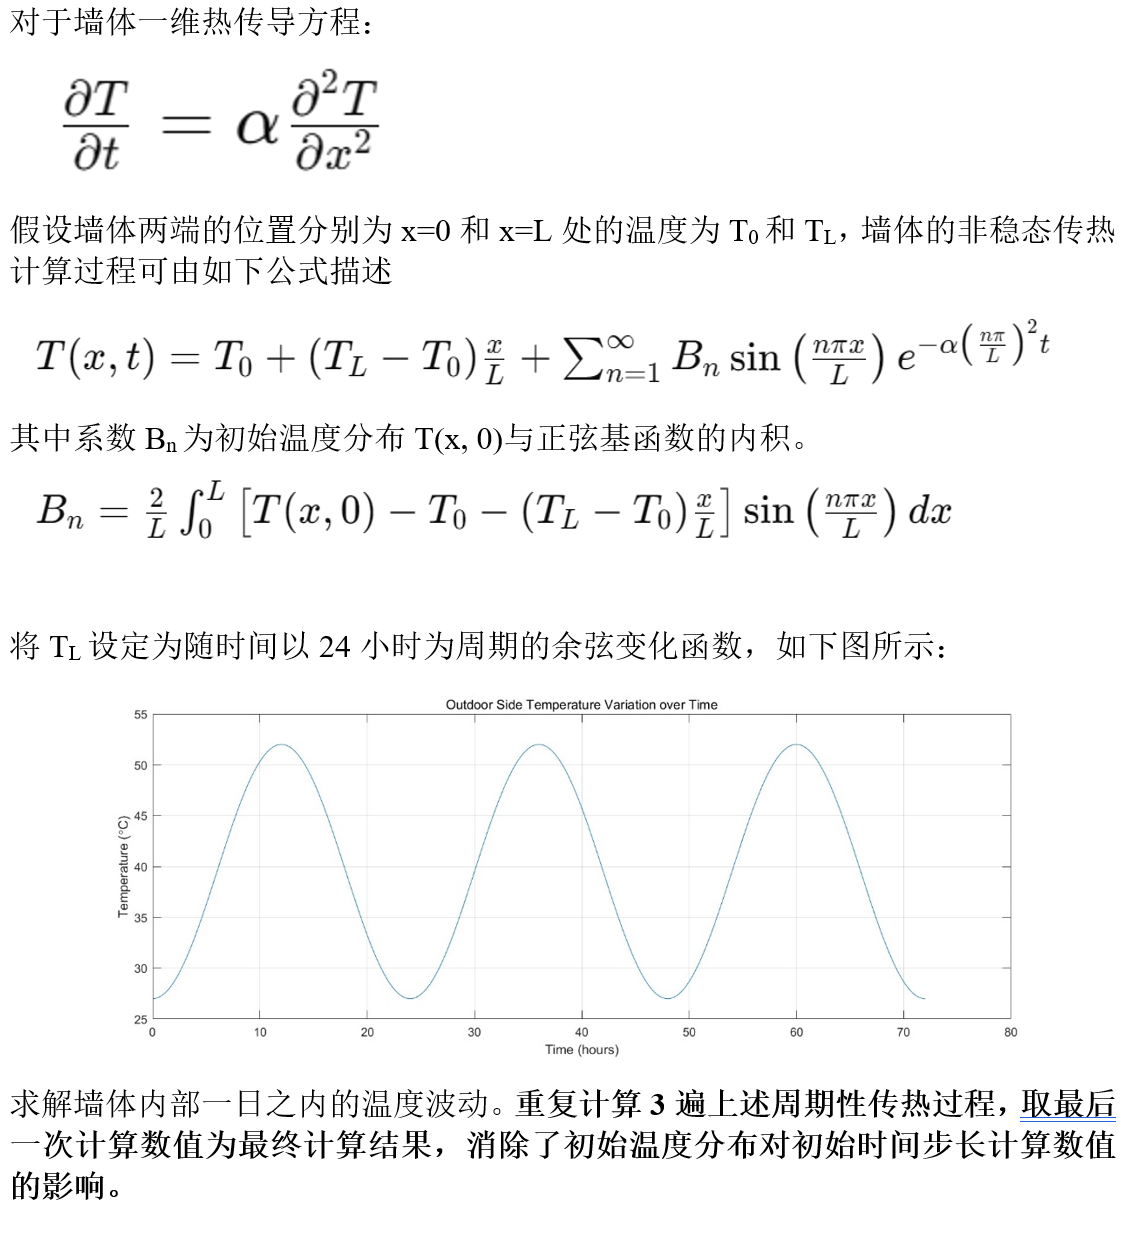

train loss: 9.28e-03 | test loss: 6.90e-02 | reg: 7.91e+00 : 100%|██| 40/40 [00:50<00:00,  1.26s/it]


fixing (0,0,0) with sin, r2=0.9982710480690002
fixing (0,0,1) with sin, r2=0.9987510442733765
fixing (0,0,2) with exp, r2=0.9985559582710266
fixing (0,0,3) with sin, r2=0.6437121033668518
fixing (0,0,4) with sin, r2=0.9634443521499634
fixing (0,1,0) with sin, r2=0.999925971031189
fixing (0,1,1) with x^2, r2=0.9999812841415405
fixing (0,1,2) with sin, r2=0.9999703764915466
fixing (0,1,3) with sin, r2=0.9999986290931702
fixing (0,1,4) with sin, r2=0.9998463988304138
fixing (1,0,0) with sin, r2=0.9856845140457153
fixing (1,1,0) with exp, r2=0.7988590002059937
fixing (1,2,0) with sin, r2=0.99956214427948
fixing (1,3,0) with x^2, r2=0.8707939982414246
fixing (1,4,0) with sin, r2=0.9807556867599487
Discovered Symbolic Formula:
[0.272*(0.144524505047859*sin(60.12*x_1 + 1.38) - 1)**2 - 19.81*sin(2.473 - 0.84*exp(-13.76*x_1)) + 1.27*sin(6.18*sin(4.31*x_1 + 6.48) - 11.08) + 0.16*sin(0.21*sin(57.57*x_1 - 0.5) - 3.627) + 44.37]
Mean Absolute Error (MAE): 0.7258741378784179
Mean Squared Error (MSE)

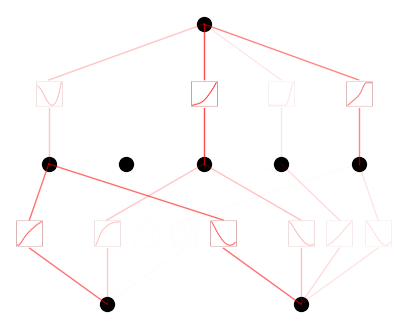

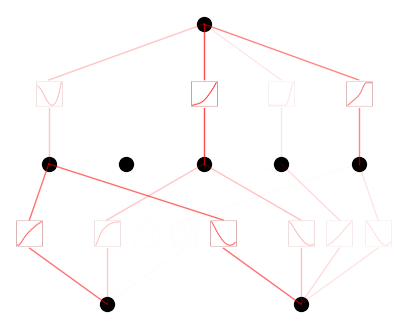

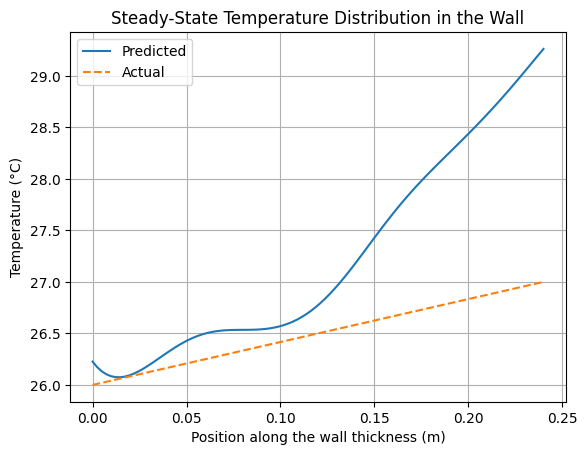

MovieWriter imagemagick unavailable; using Pillow instead.


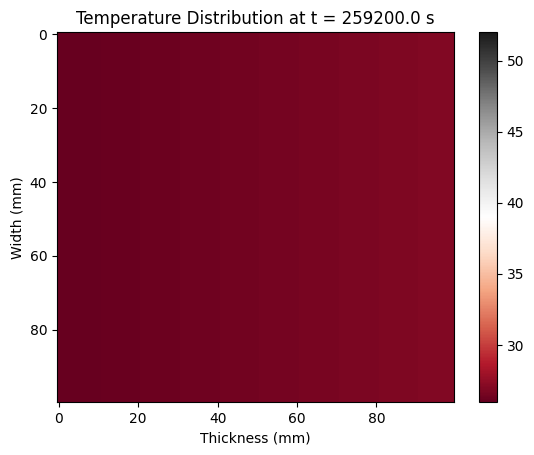

MovieWriter imagemagick unavailable; using Pillow instead.


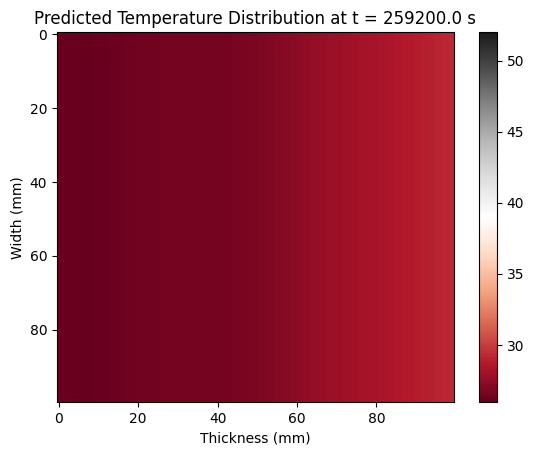

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import KAN, add_symbolic
from matplotlib.animation import FuncAnimation

# Parameters
L1 = 0.24  # Thickness of the concrete layer in meters (240mm)
L2 = 0.05  # Thickness of the insulation layer in meters (50mm)
W = 1.0    # Wall width in meters (1000mm)
alpha = 2.5e-6  # Thermal diffusivity in m^2/s
T0 = 26    # Temperature at x=0 in Celsius
Ti = 25    # Initial average temperature in Celsius
t_final = 3600 * 24 * 3  # Total time in seconds (3 days)
amplitude = 12.5
meanTemp = 39.5
period = 86400  # 24-hour period
phaseShift = -2 * np.pi / period * (12 * 3600)  # Phase shift for the peak at 12 hours

# Time and space grids
x = np.linspace(0, L1, 100)  # Space grid along wall thickness
t = np.linspace(0, t_final, 288 * 3)  # Time grid for 72 hours

# Initialize temperature data storage
TemperatureData = np.zeros((len(t), len(x)))

# Compute temperature distribution
N = 30  # Number of Fourier series terms
for k in range(len(t)):
    TL = amplitude * np.cos(2 * np.pi / period * t[k] + phaseShift) + meanTemp
    for i in range(len(x)):
        Temperature = T0 + (TL - T0) * x[i] / L1
        for n in range(1, N + 1):
            Bn = 2 / (n * np.pi) * ((-1) ** n - 1) * (TL - T0 - (Ti - T0)) / L1
            Temperature += Bn * np.sin(n * np.pi * x[i] / L1) * np.exp(-alpha * (n * np.pi / L1) ** 2 * t[k])
        TemperatureData[k, i] = Temperature

# Use the last day's data for training and testing
TemperatureData2draw = TemperatureData[288 * 2 + 1:288 * 3, :]

# Prepare the data
t_last_day = t[288 * 2 + 1:288 * 3]
x_data = np.array([[x_val, t_val] for t_val in t_last_day for x_val in x])
y_data = TemperatureData2draw.flatten()

# Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data)
y_std = np.std(y_data)

x_data_normalized = (x_data - x_mean) / x_std
y_data_normalized = (y_data - y_mean) / y_std

# Convert to tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32).unsqueeze(1)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Train the model using the tutorial's approach
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=40, lamb=0.001, lamb_entropy=2.0)
# model.train(dataset, opt="LBFGS", steps=90, lamb=0, lamb_entropy=10.0)
# Automatically set activation functions to be symbolic
lib = ['x', 'exp', 'sin', 'x^2']
model.auto_symbolic(lib=lib)

# Prune the model
model.prune()

# Plot the model
model.plot()
model.plot(mask=True)

# Obtain the symbolic formula and denormalize it
symbolic_formula, x0 = model.symbolic_formula(normalizer=[x_mean, x_std], output_normalizer=[[y_mean], [y_std]])

print("Discovered Symbolic Formula:")
print(symbolic_formula)

# Evaluate the final accuracy of the prediction
x_test = np.array([[x_val, t_final] for x_val in x])  # Use the final time step for testing
x_test_normalized = (x_test - x_mean) / x_std
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

predicted_temperature_normalized = model(x_test_tensor).detach().numpy().flatten()
predicted_temperature = predicted_temperature_normalized * y_std + y_mean

# Calculate metrics
mae = mean_absolute_error(TemperatureData[-1, :], predicted_temperature)
mse = mean_squared_error(TemperatureData[-1, :], predicted_temperature)
r2 = r2_score(TemperatureData[-1, :], predicted_temperature)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Create output directory for plots
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Plot predicted temperature distribution
plt.figure()
plt.plot(x, predicted_temperature, label='Predicted')
plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
plt.xlabel('Position along the wall thickness (m)')
plt.ylabel('Temperature (°C)')
plt.title('Steady-State Temperature Distribution in the Wall')
plt.legend()
plt.grid(True)
plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()

# Generate GIF of temperature distribution over time
fig, ax = plt.subplots()
cax = ax.imshow(np.tile(TemperatureData2draw[0, :], (100, 1)), aspect='auto', cmap='RdGy', vmin=T0, vmax=amplitude + meanTemp)
fig.colorbar(cax)
ax.set_xlabel('Thickness (mm)')
ax.set_ylabel('Width (mm)')
ax.set_title(f'Temperature Distribution at t = {t_last_day[0]} s')

def update(frame):
    ax.clear()
    cax = ax.imshow(np.tile(TemperatureData2draw[frame, :], (100, 1)), aspect='auto', cmap='RdGy', vmin=T0, vmax=amplitude + meanTemp)
    ax.set_xlabel('Thickness (mm)')
    ax.set_ylabel('Width (mm)')
    ax.set_title(f'Temperature Distribution at t = {t_last_day[frame]} s')

ani = FuncAnimation(fig, update, frames=len(t_last_day), repeat=False)
ani.save(f'{outputDir}/OriginalTemperatureAnimation.gif', writer='imagemagick', fps=10)

plt.show()

# Generate GIF of predicted temperature distribution over time
predicted_temperature_full = model(x_tensor).detach().numpy().reshape(len(t_last_day), len(x))
predicted_temperature_full = predicted_temperature_full * y_std + y_mean  # Denormalize the prediction

fig, ax = plt.subplots()
cax = ax.imshow(np.tile(predicted_temperature_full[0, :], (100, 1)), aspect='auto', cmap='RdGy', vmin=T0, vmax=amplitude + meanTemp)
fig.colorbar(cax)
ax.set_xlabel('Thickness (mm)')
ax.set_ylabel('Width (mm)')
ax.set_title(f'Predicted Temperature Distribution at t = {t_last_day[0]} s')

def update_pred(frame):
    ax.clear()
    cax = ax.imshow(np.tile(predicted_temperature_full[frame, :], (100, 1)), aspect='auto', cmap='RdGy', vmin=T0, vmax=amplitude + meanTemp)
    ax.set_xlabel('Thickness (mm)')
    ax.set_ylabel('Width (mm)')
    ax.set_title(f'Predicted Temperature Distribution at t = {t_last_day[frame]} s')

ani_pred = FuncAnimation(fig, update_pred, frames=len(t_last_day), repeat=False)
ani_pred.save(f'{outputDir}/PredictedTemperatureAnimation.gif', writer='imagemagick', fps=10)

plt.show()


In [5]:
model.suggest_symbolic(0,0,0)

function , r2
sin , 1.0000003576278687
gaussian , 0.9999903440475464
sigmoid , 0.9999871850013733
tanh , 0.9999871253967285
arctan , 0.9999619722366333


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 1.0000003576278687)

In [6]:
model.suggest_symbolic(0,1,0)

function , r2
sin , 1.000000238418579
gaussian , 0.37496304512023926
x^3 , 0.2843291461467743
tanh , 0.27922916412353516
sigmoid , 0.26827868819236755


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 1.000000238418579)

In [7]:
model.suggest_symbolic(1,0,0)

function , r2
sin , 1.0000003576278687
gaussian , 0.9992163777351379
abs , 0.9806748032569885
x^2 , 0.9300867319107056
cosh , 0.9298790097236633


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 1.0000003576278687)

In [4]:
model.symbolic_formula()[0][0]

0.09*(0.1*sin(4.21*x_1 + 8.59) - sin(2.17*x_2 + 9.24) - 0.47)**2 - 0.2*sin(-6.18*sin(0.3*x_1 + 7.0) + 0.72*sin(3.32*x_2 + 8.92) + 11.71) + 0.03*sin(0.21*sin(4.03*x_1 + 6.41) + 0.66*sin(4.59*x_2 + 6.81) - 2.97) - 3.07*sin(0.21*sin(3.51*x_2 + 5.23) + 2.5 - 0.16*exp(-0.96*x_1)) + 1.8